# Self-Driving Car Engineer Nanodegree


## Vehicle Detection Project

I have setup a ipython notebook to work on Vehicle Detection Project


## Import Packages

In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import glob
import os
import random
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

%matplotlib inline

## Get Images

For obtaining images i referred to the example below.
Referred to example from https://www.pythoncentral.io/how-to-traverse-a-directory-tree-in-python-guide-to-os-walk/

In [2]:
def get_images(path):
    images = []
    for dirs, subdir, files in os.walk(path):
        print(dirs, subdir)
        for file in files:
            if '.DS_Store' not in file:
                images.append(os.path.join(dirs, file))
                
    return list(map(lambda img: mpimg.imread(img), images))




## Obtain Vehicle Images

In [3]:
#vehicle_path = '../car-vehicle-detection/vehicles/vehicles'
vehicle_path = '../vehicles'
vehicles = get_images(vehicle_path)
print(len(vehicles))



../vehicles ['GTI_MiddleClose', 'GTI_Right', 'GTI_Far', 'KITTI_extracted', 'GTI_Left']
../vehicles/GTI_MiddleClose []
../vehicles/GTI_Right []
../vehicles/GTI_Far []
../vehicles/KITTI_extracted []
../vehicles/GTI_Left []
8792


## Obtain Non Vehicle Images

In [4]:
#non_vehicle_path = '../car-vehicle-detection/non-vehicles/non-vehicles'
non_vehicle_path = '../non-vehicles'
non_vehicles = get_images(non_vehicle_path)
print(len(non_vehicles))

../non-vehicles ['GTI', 'Extras']
../non-vehicles/GTI []
../non-vehicles/Extras []
8968


## Output Some Example images

Below is display some vehicle and non vehicle images. I have chosen to randomly output 5 vehicle and 5 non vehicle images.

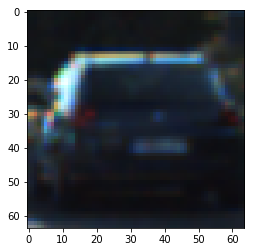

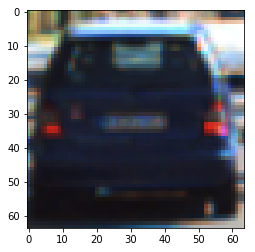

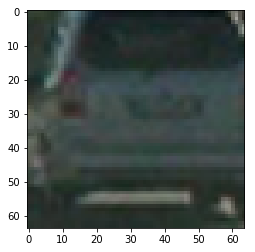

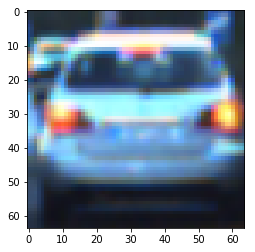

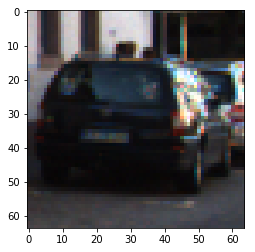

In [5]:
number_of_vehicle_images = 5

for i in range(number_of_vehicle_images):
    index = random.randint(0, len(vehicles))
    image = vehicles[index]
    #plt.figure(figsize=(20,3))
    plt.imshow(image)
    plt.show()

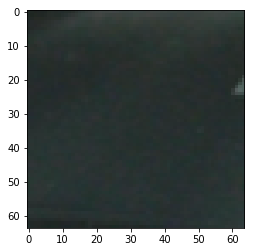

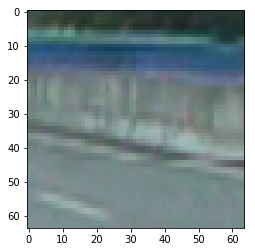

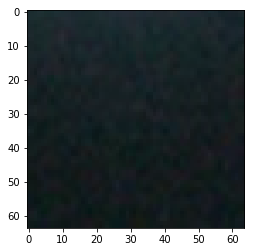

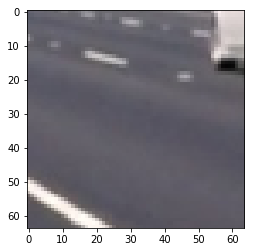

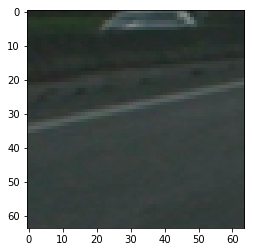

In [6]:
number_of_non_vehicle_images = 5

for i in range(number_of_non_vehicle_images):
    index = random.randint(0, len(non_vehicles))
    image = non_vehicles[index]
    #plt.figure(figsize=(20,3))
    plt.imshow(image)
    plt.show()

## Project Helper Functions

The following helper functions are used in the main project implementation.

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


## Display Hog Features


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


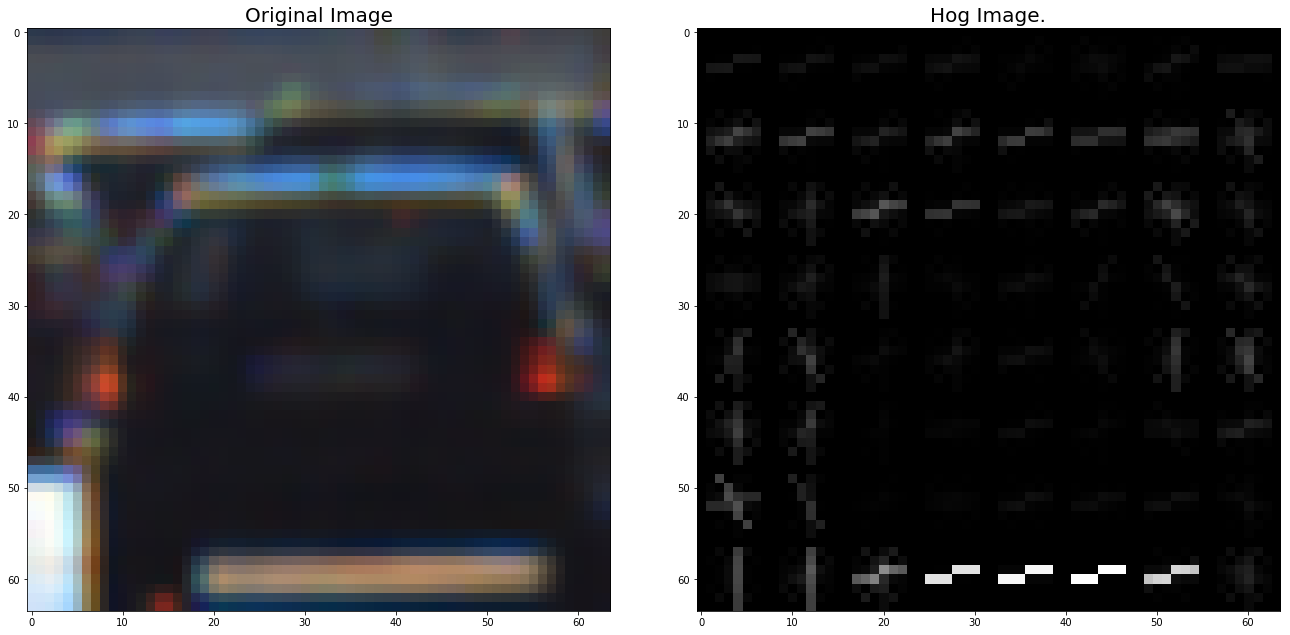

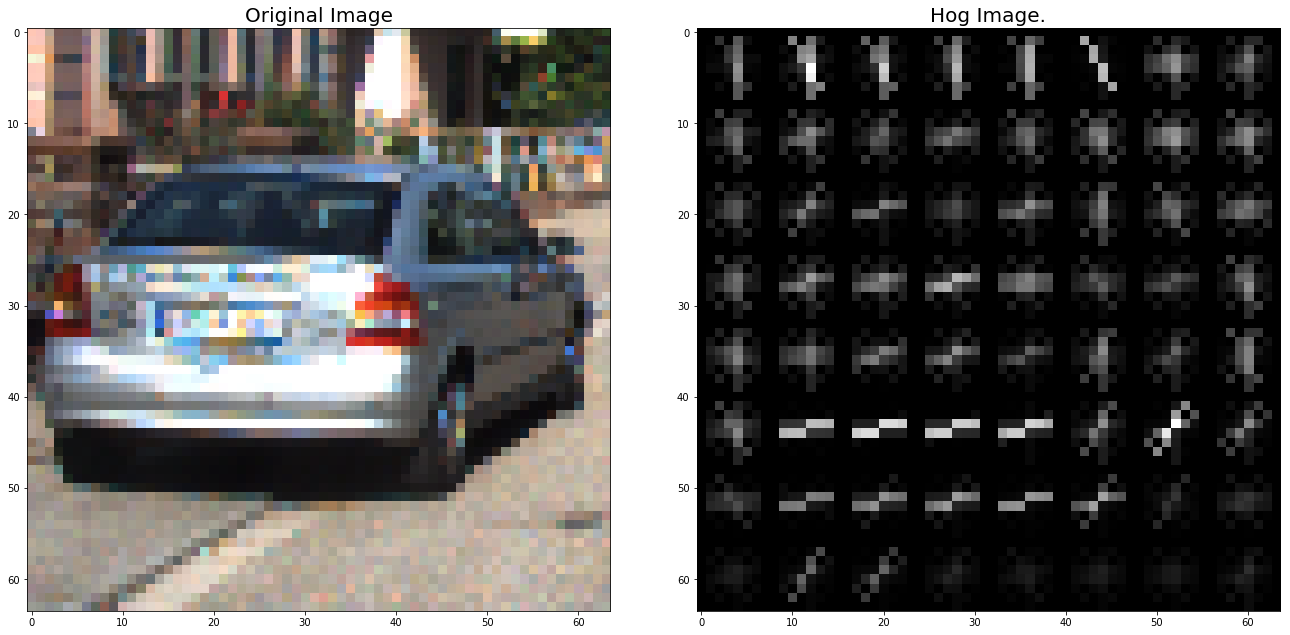

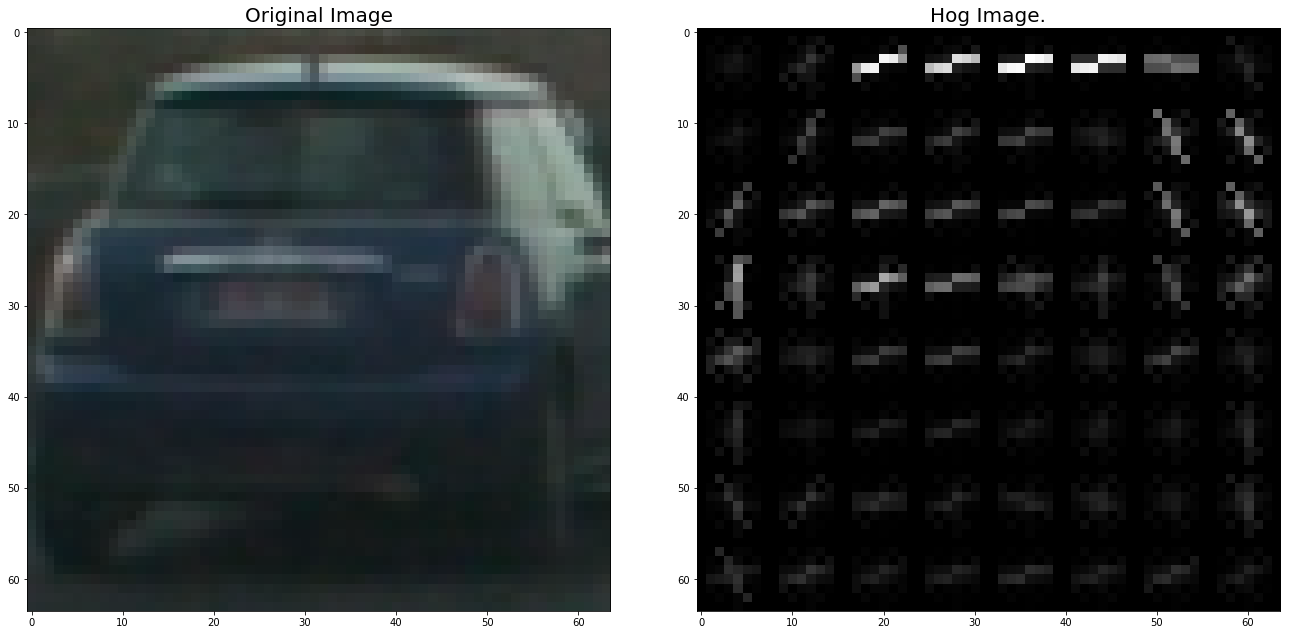

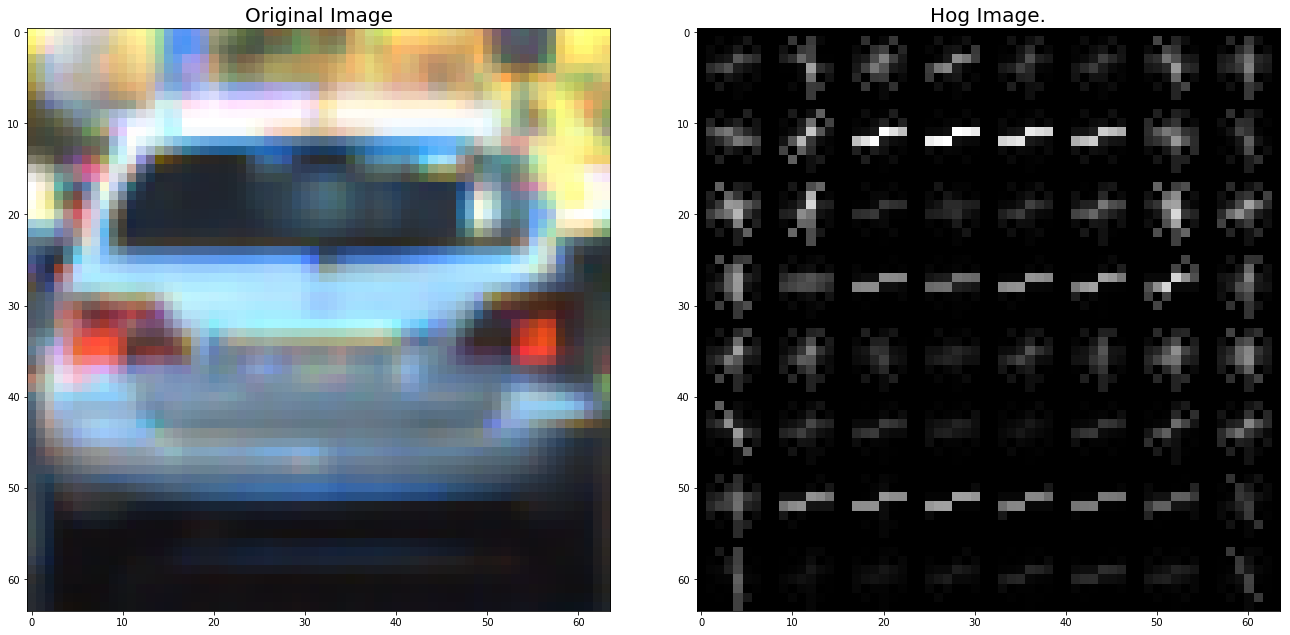

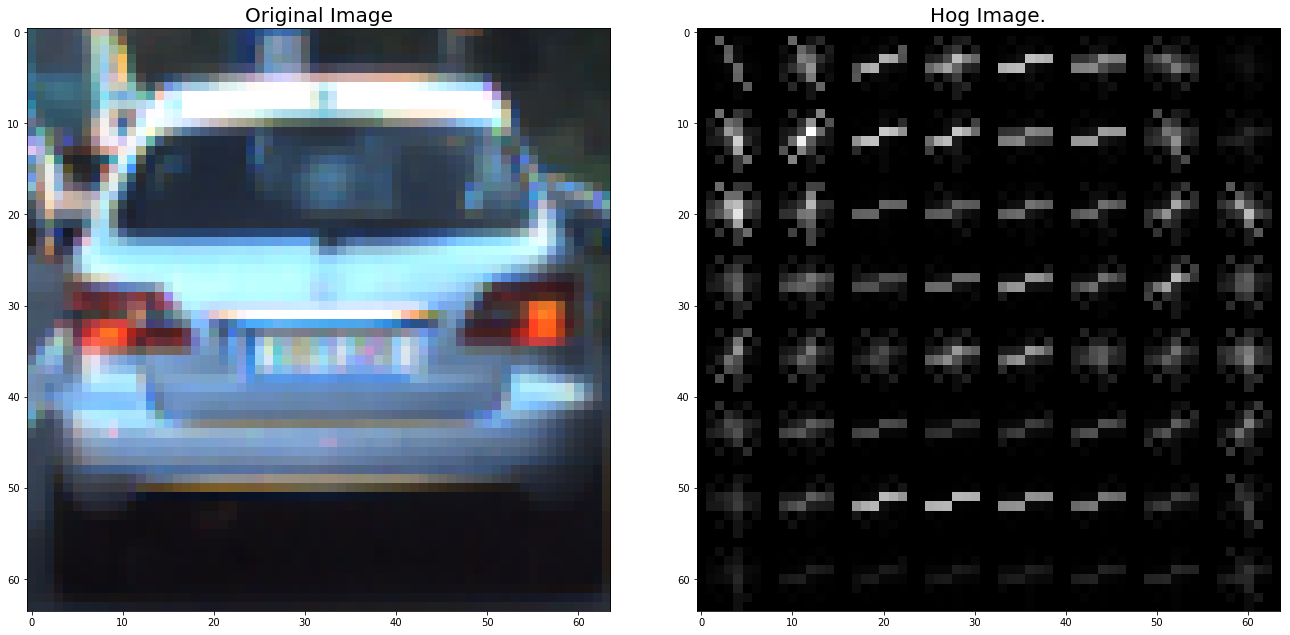

In [8]:
for i in range(number_of_vehicle_images):
    index = random.randint(0, len(vehicles))
    image = vehicles[index]

    features, hog_image = get_hog_features(image[:,:,0], 9, 8, 2, True, True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('Hog Image.', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


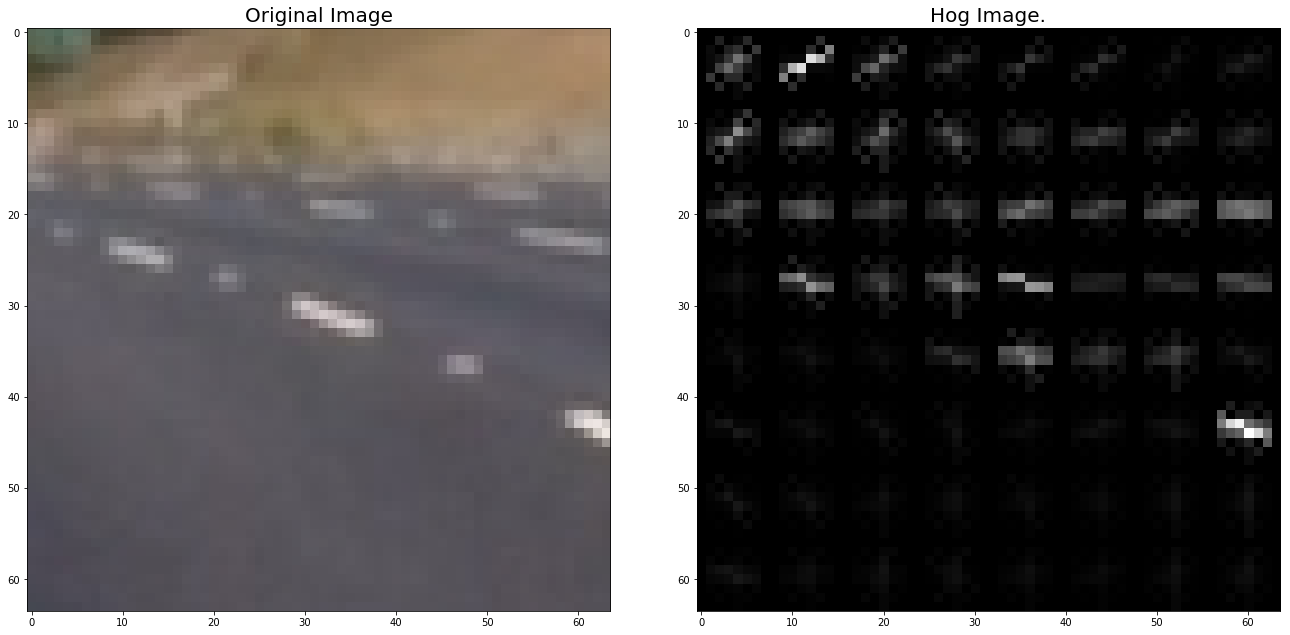

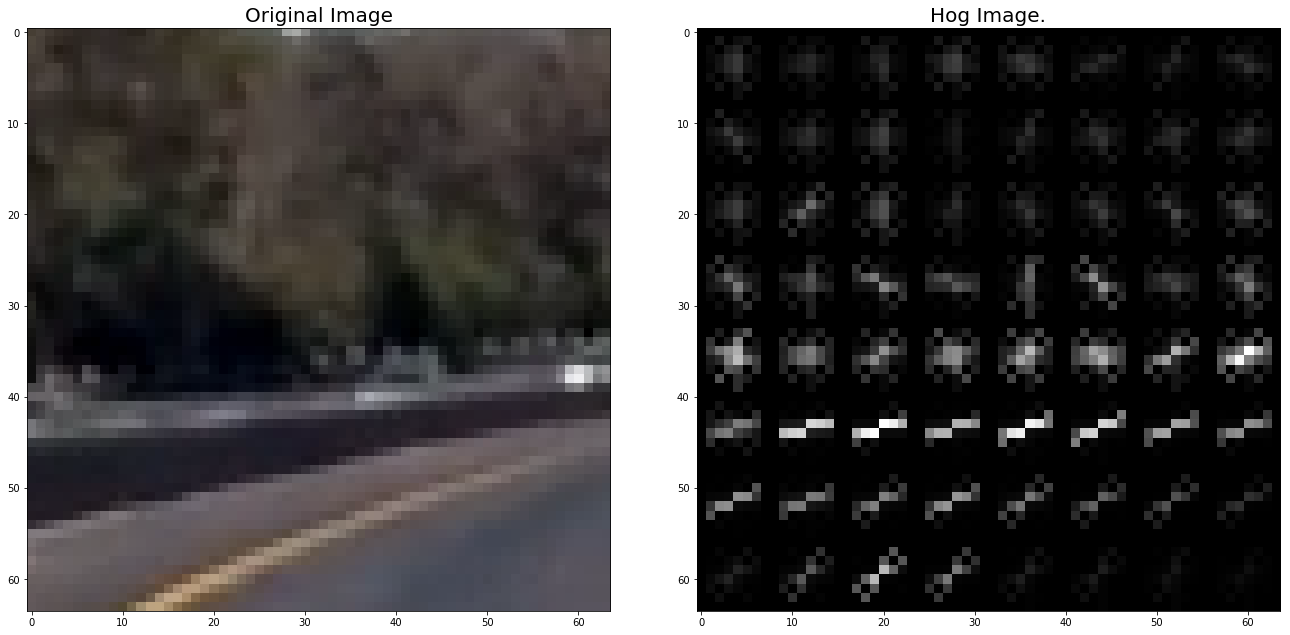

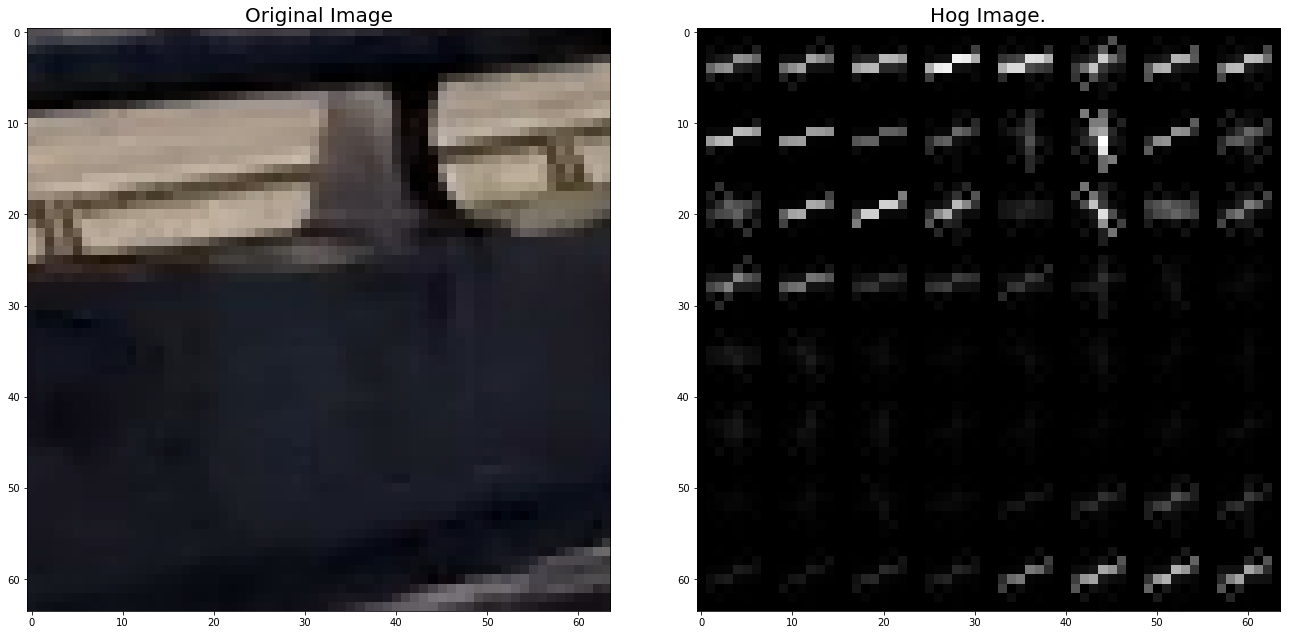

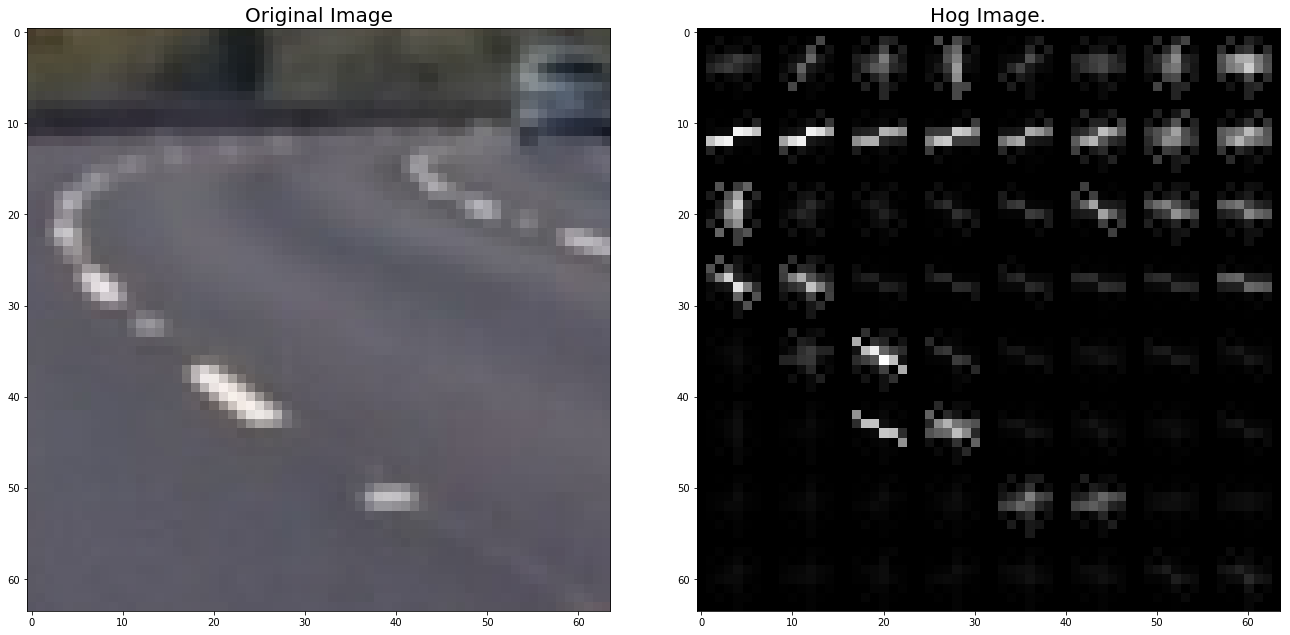

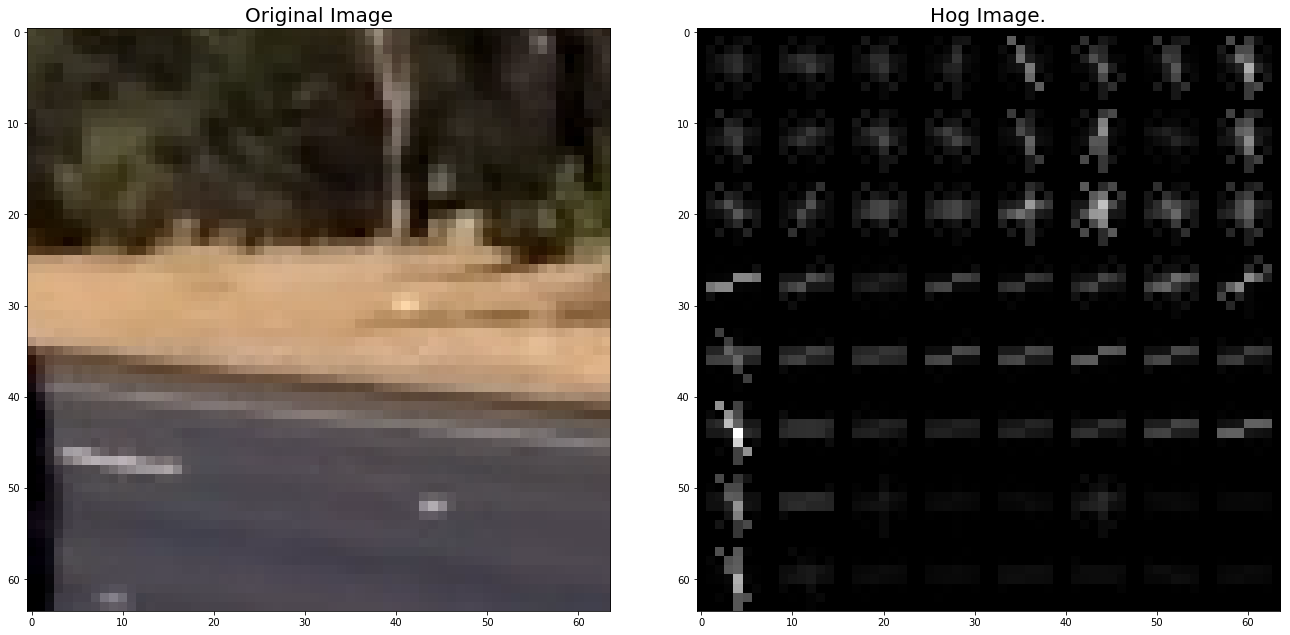

In [9]:
for i in range(number_of_non_vehicle_images):
    index = random.randint(0, len(non_vehicles))
    image = non_vehicles[index]

    features, hog_image = get_hog_features(image[:,:,0], 9, 8, 2, True, True)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title('Hog Image.', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        image_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            image_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            image_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            image_features.append(hog_features)
        features.append(np.concatenate(image_features))
    # Return list of feature vectors
    return features

In [11]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [12]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Parameters for extracting features

Settled for these after several trials.

In [13]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#color_space = 'HSV'
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 16
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

## Extract Features

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


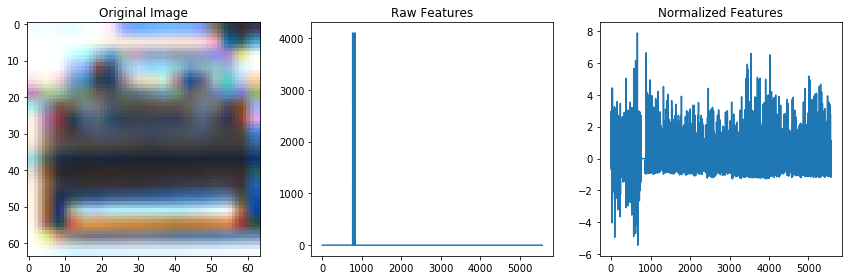

In [14]:
car_features = extract_features(vehicles[0:8790], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles[0:8790], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(vehicles))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow((vehicles[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## SVM Model

In [15]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of size',spatial,
    'and', hist_bins,'histogram bins')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of size 16 and 32 histogram bins
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
17.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9878
My SVC predicts:  [ 1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.
  1.  1.]
For these 20 labels:  [ 1.  1.  0.  1.  1.  1.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.
  1.  1.]
0.00492 Seconds to predict 20 labels with SVC


## Use Pickle to Load and Save model

In [16]:
vd_pickle = {}
vd_pickle["svc"] = svc
vd_pickle["x_scalar"] = X_scaler

pickle.dump(vd_pickle, open("vehicle_detection.p", "wb" ))



In [17]:
vehicle_pickle = pickle.load(open("vehicle_detection.p", "rb"))
svc = vehicle_pickle["svc"]
X_scaler = vehicle_pickle["x_scalar"]

## Find Cars


The function below returns both an output image and a window list.

In [18]:
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    window_list = []
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    #print(img_tosearch.shape)
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #print(nxsteps)
    #print(nysteps)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left + xstart, ytop_draw+ystart),(xbox_left + win_draw + xstart,ytop_draw+win_draw+ystart),(0,0,255),6)
                window_list.append(((xbox_left + xstart, ytop_draw+ystart), (xbox_left + win_draw + xstart,ytop_draw+win_draw+ystart)))
                
    #print(window_list)
    
    return draw_img, window_list

## Load Test Images

Number of images =  8


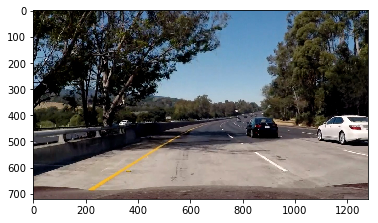

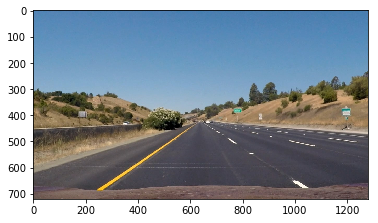

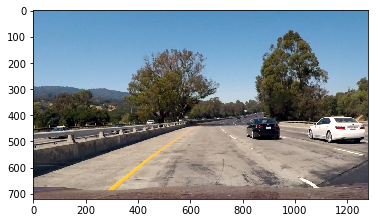

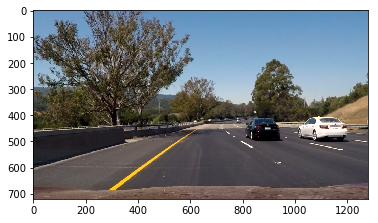

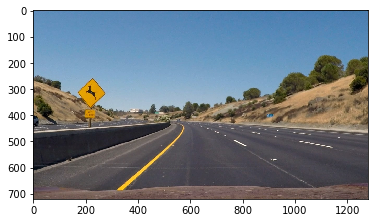

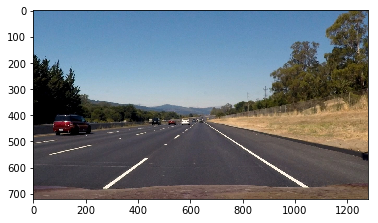

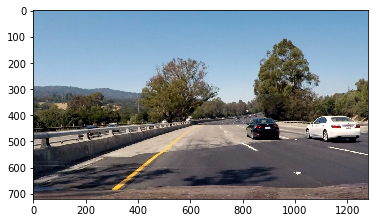

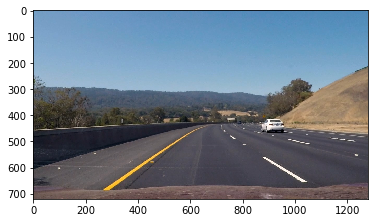

In [19]:
test_images = [mpimg.imread('test_images/' + i) for i in os.listdir('test_images/')]

print("Number of images = ", len(test_images))

for i in range(len(test_images)):
    img = test_images[i]

    #image_to_search = img[336:656,640:1280,:]
    #print(image_to_search.shape)
    
    plt.imshow(test_images[i])
    plt.show()

## Hog Sampled Images

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


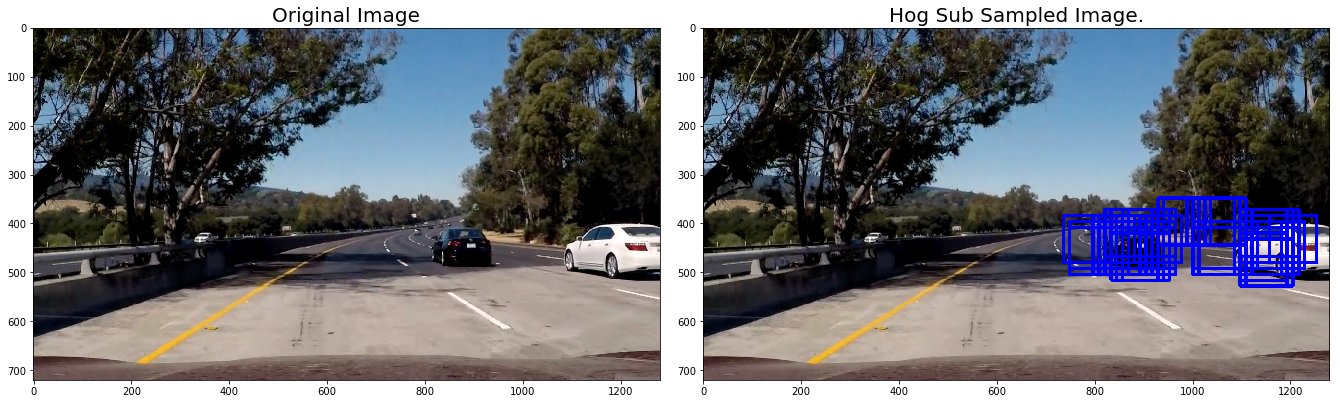

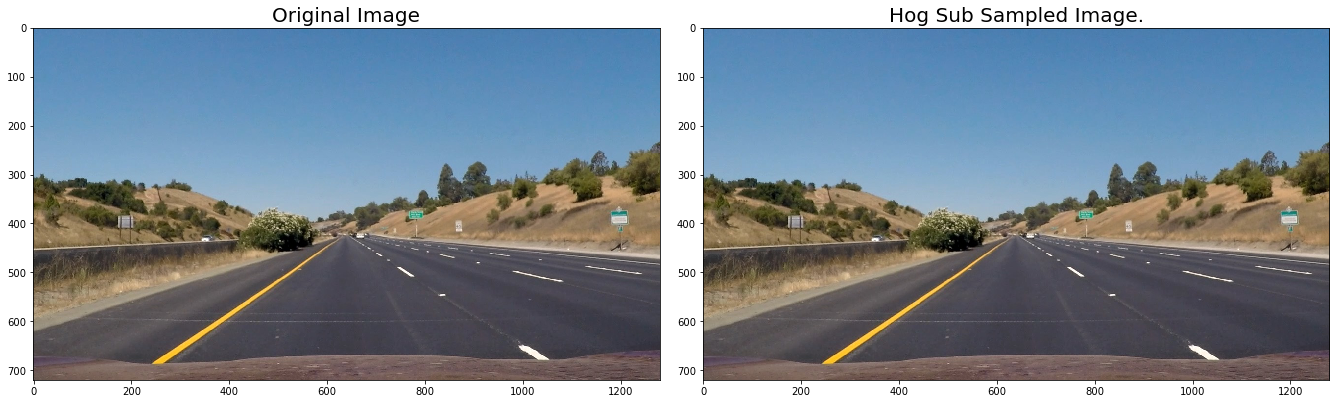

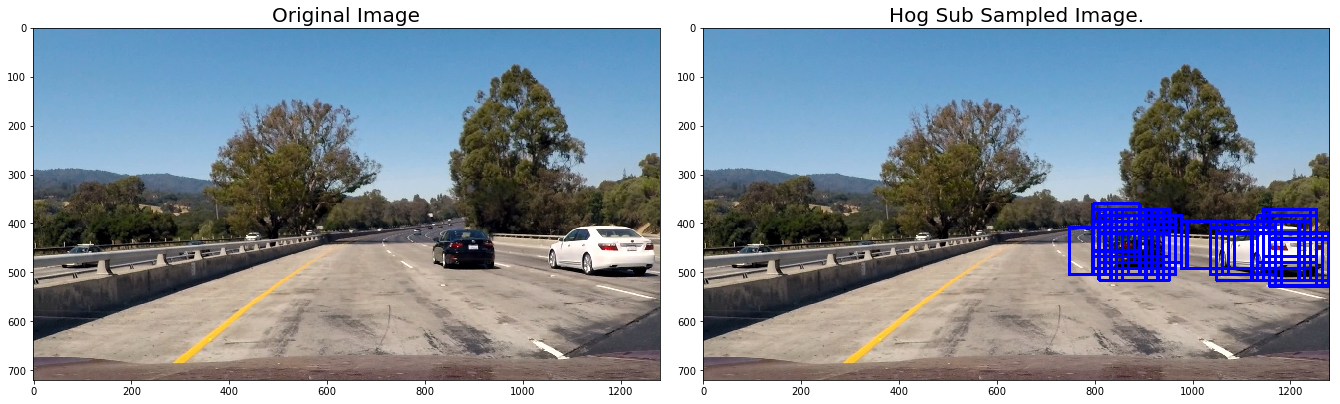

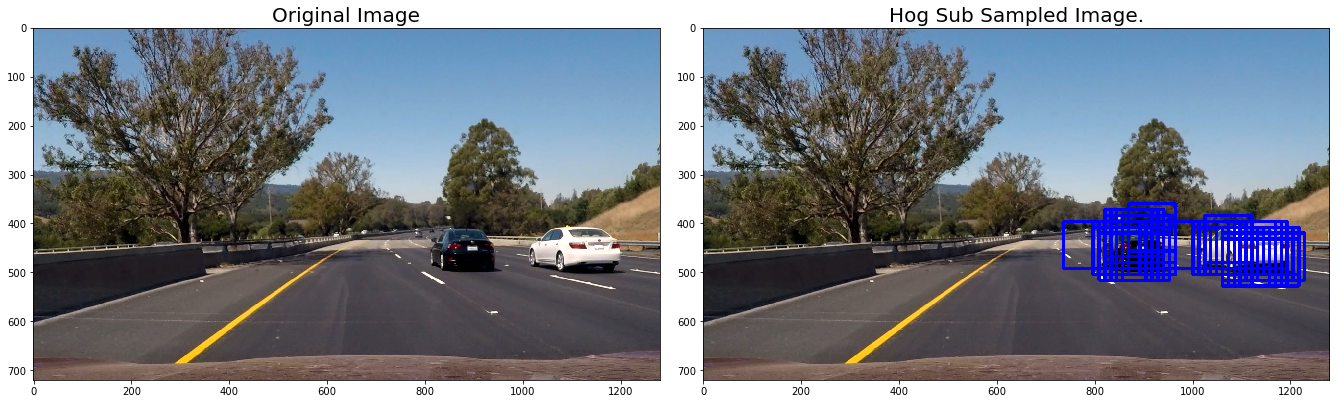

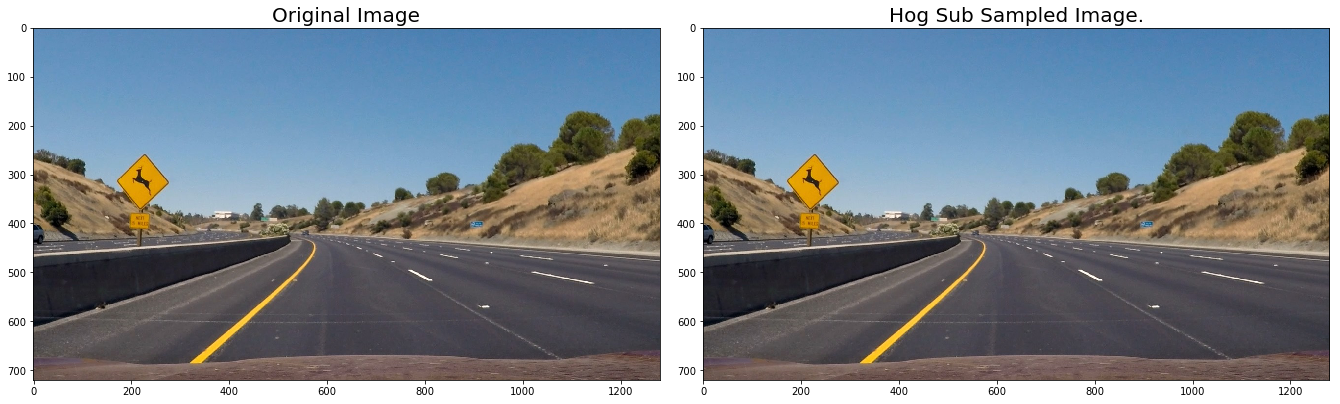

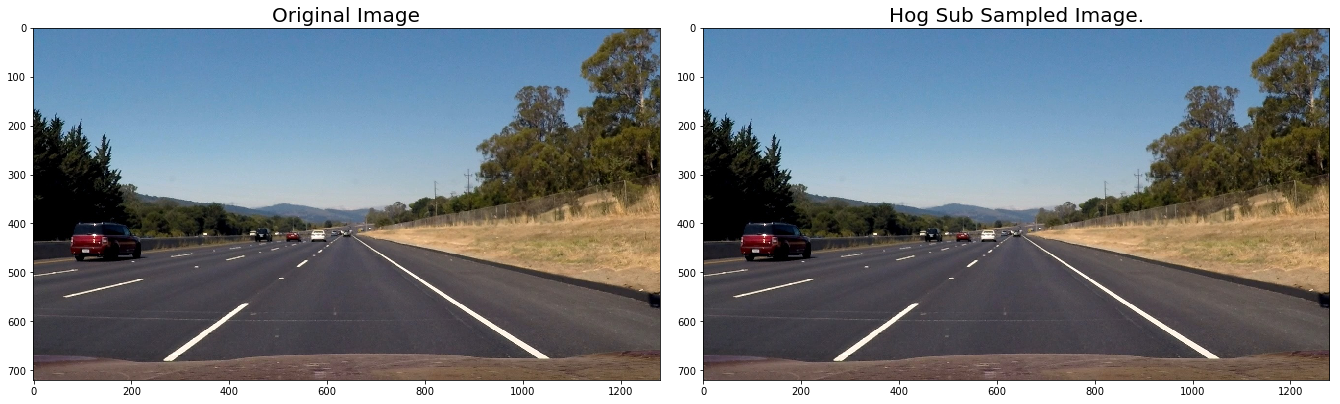

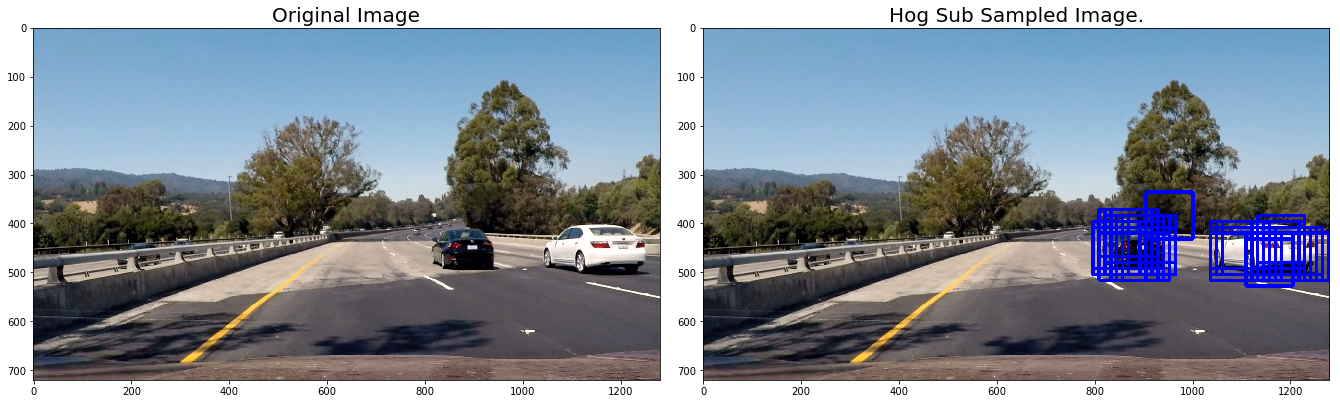

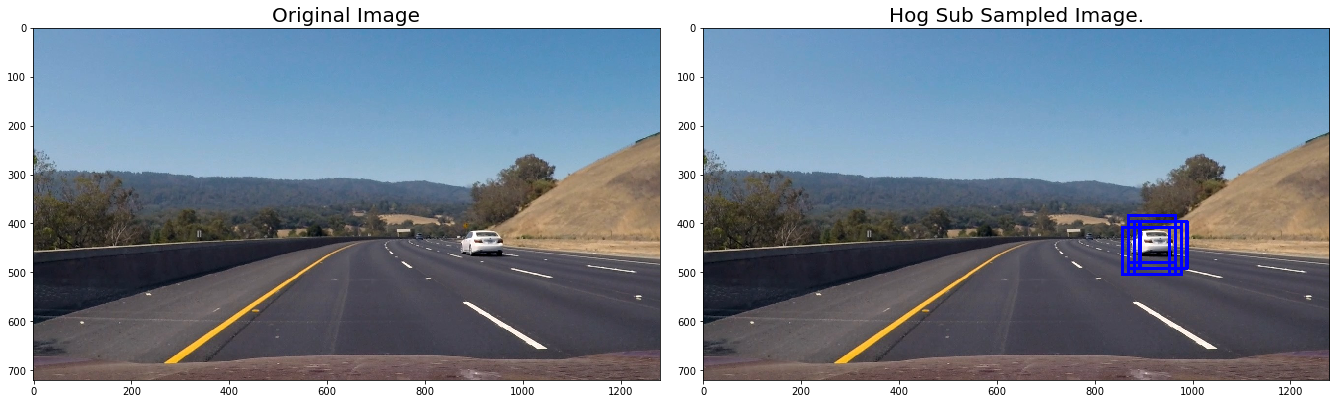

In [20]:
ystart1 = 336
ystop1 = 656
scale1 = 1.5

ystart2 = 350
ystop2 = 550
scale2 = 1.8

ystart3 = 450
ystop3 = 680
scale3 = 2

ystart4 = 500
ystop4 = 700
scale4 = 1

for i in range(6):
    #test_images[i] = test_images[i].astype(np.float32)/255
    
    #image_to_search = test_images[i][336:656,640:1280,:]
    #out_img, window_list1 = find_cars(image_to_search, 0, 320, 0, 640, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    
    out_img, window_list1 = find_cars(test_images[i], 336, 656, 640, 1280, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #out_img, window_list2 = find_cars(out_img, ystart2, ystop2, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #out_img, window_list3 = find_cars(out_img, ystart3, ystop3, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #out_img, window_list4 = find_cars(out_img, ystart4, ystop4, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    f.tight_layout()
    ax1.imshow(test_images[i])
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(out_img, cmap='gray')
    ax2.set_title('Hog Sub Sampled Image.', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

## Helper Functions for Adding Heat

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Output Images

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


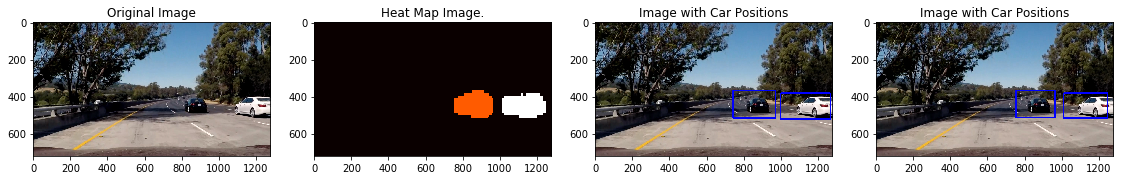

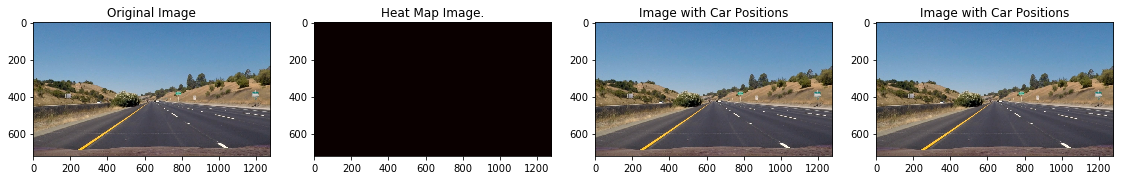

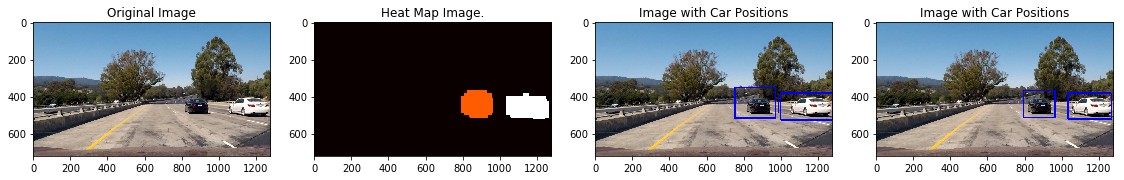

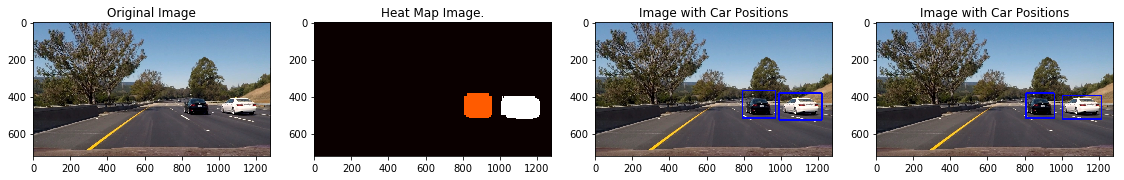

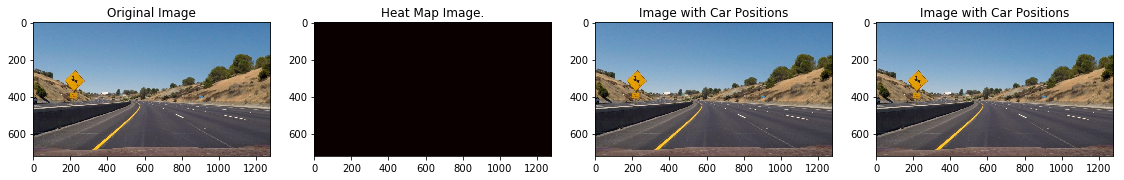

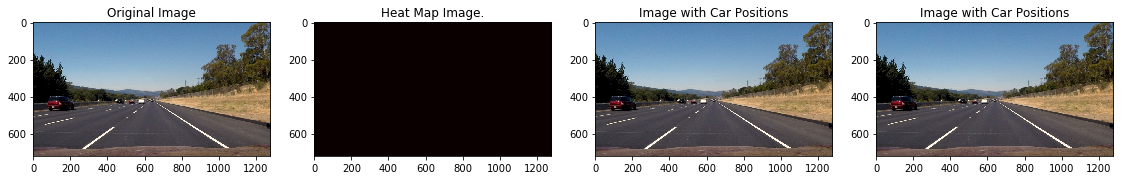

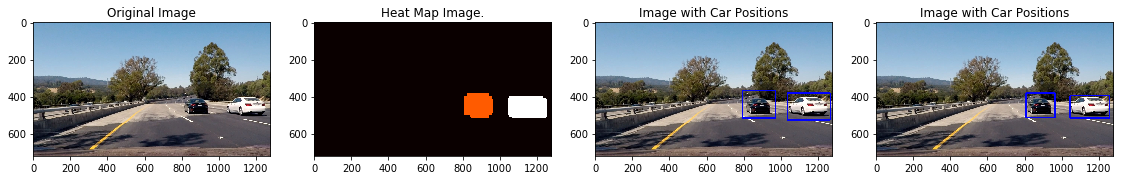

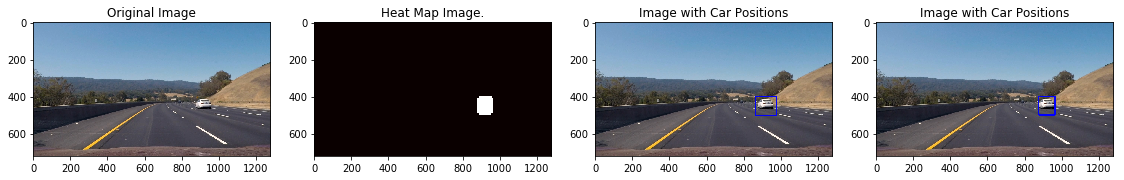

In [22]:
from scipy.ndimage.measurements import label

xstart = 640
xstop = 1280

ystart1 = 400
ystop1 = 656
scale1 = 1.4

ystart2 = 400
ystop2 = 592
scale2 = 1.6

ystart3 = 336
ystop3 = 528
scale3 = 1.9

ystart4 = 370
ystop4 = 490
scale4 = 2

for i in range(6):
    heat = np.zeros_like(test_images[i][:,:,0]).astype(np.float)
    out_img, window_list1 = find_cars(test_images[i], ystart1, ystop1, xstart, xstop, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    out_img, window_list2 = find_cars(test_images[i], ystart2, ystop2, xstart, xstop, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img, window_list3 = find_cars(test_images[i], ystart3, ystop3, xstart, xstop, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #out_img, window_list4 = find_cars(test_images[i], ystart4, ystop4, xstart, xstop, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #print(window_list)
    
    #window_list = window_list1 + window_list2 + window_list3 + window_list4
    #window_list = window_list1
    window_list = window_list1 + window_list2 + window_list3
    
    # Add heat to each box in box list
    heat = add_heat(heat, window_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_images[i]), labels)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img1 = draw_labeled_bboxes(np.copy(test_images[i]), labels)
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(test_images[i])
    ax1.set_title('Original Image', fontsize=12)
    ax2.imshow(labels[0], cmap='hot')
    ax2.set_title('Heat Map Image.', fontsize=12)
    ax3.imshow(draw_img, cmap='gray')
    ax3.set_title('Image with Heat Thresh 2', fontsize=12)
    ax4.imshow(draw_img1, cmap='gray')
    ax4.set_title('Image with Heat Thresh 5', fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

## Setup Image Pipeline

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
def pipeline(test_image):
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    out_img, window_list1 = find_cars(test_image, ystart1, ystop1, xstart, xstop, scale1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    out_img, window_list2 = find_cars(test_image, ystart2, ystop2, xstart, xstop, scale2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    out_img, window_list3 = find_cars(test_image, ystart3, ystop3, xstart, xstop, scale3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #out_img, window_list4 = find_cars(test_image, ystart4, ystop4, scale4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    #window_list = window_list1 + window_list2 + window_list3 + window_list4
    window_list = window_list1 + window_list2 + window_list3
    
    # Add heat to each box in box list
    heat = add_heat(heat, window_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
    
    return draw_img
    

In [25]:
def process_image(image):
    return pipeline(image)

## Generate Output Videos

### Test Video

In [26]:
output_video = './output_videos/test_video.mp4'
clip = VideoFileClip('./test_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video.mp4
[MoviePy] Writing video ./output_videos/test_video.mp4


 97%|█████████▋| 38/39 [00:51<00:01,  1.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video.mp4 

CPU times: user 53.9 s, sys: 92 ms, total: 54 s
Wall time: 53.1 s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

### Project Video

In [28]:
output_video = './output_videos/output_video.mp4'
clip = VideoFileClip('./project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_videos/output_video.mp4
[MoviePy] Writing video ./output_videos/output_video.mp4


100%|█████████▉| 1260/1261 [28:20<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/output_video.mp4 

CPU times: user 29min 47s, sys: 2.56 s, total: 29min 50s
Wall time: 28min 21s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

